##  Enosh Nyarige 
### Data Mining Final Project
#### Credit Card Fraud Detection

##### Jan - April 2021

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set_style("whitegrid")

In [58]:
from pylab import rcParams

rcParams['figure.figsize'] = 14, 8

## 1. Methods applied to acquire data

### Data related to this project was downloaded from Kaggle's respository, https://www.kaggle.com/mlg-ulb/creditcardfraud 

- Loading the downloaded dataset

In [59]:
!ls

creditCard_fraudDetection-Copy1.ipynb  dataset	README.md
creditCard_fraudDetection.ipynb        models


In [60]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

In [61]:
data = pd.read_csv("dataset/creditcard.csv")
data.head(2)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0


In [62]:
data.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')

- In this dataset, we can only use Time, Amount and Class columns. 

- The class feature is in the form of: 
    - 1: fraud
    - 0: not_fraud

- From the Class feature, the value counts for the two labels is 284315 and 492 for not_fraud and fraud respectively

In [63]:
data.Class.value_counts()

0    284315
1       492
Name: Class, dtype: int64

In [64]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

- Correlation matrix

In [78]:
corrmat = data.corr()

In [82]:
corrmat

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
Time,1.000000,1.173963e-01,-1.059333e-02,-4.196182e-01,-1.052602e-01,1.730721e-01,-6.301647e-02,8.471437e-02,-3.694943e-02,-8.660434e-03,...,4.473573e-02,1.440591e-01,5.114236e-02,-1.618187e-02,-2.330828e-01,-4.140710e-02,-5.134591e-03,-9.412688e-03,-0.010596,-0.012323
V1,0.117396,1.000000e+00,4.135835e-16,-1.227819e-15,-9.215150e-16,1.812612e-17,-6.506567e-16,-1.005191e-15,-2.433822e-16,-1.513678e-16,...,-2.457409e-16,-4.290944e-16,6.168652e-16,-4.425156e-17,-9.605737e-16,-1.581290e-17,1.198124e-16,2.083082e-15,-0.227709,-0.101347
V2,-0.010593,4.135835e-16,1.000000e+00,3.243764e-16,-1.121065e-15,5.157519e-16,2.787346e-16,2.055934e-16,-5.377041e-17,1.978488e-17,...,-8.480447e-17,1.526333e-16,1.634231e-16,1.247925e-17,-4.478846e-16,2.057310e-16,-4.966953e-16,-5.093836e-16,-0.531409,0.091289
V3,-0.419618,-1.227819e-15,3.243764e-16,1.000000e+00,4.711293e-16,-6.539009e-17,1.627627e-15,4.895305e-16,-1.268779e-15,5.568367e-16,...,5.706192e-17,-1.133902e-15,-4.983035e-16,2.686834e-19,-1.104734e-15,-1.238062e-16,1.045747e-15,9.775546e-16,-0.210880,-0.192961
V4,-0.105260,-9.215150e-16,-1.121065e-15,4.711293e-16,1.000000e+00,-1.719944e-15,-7.491959e-16,-4.104503e-16,5.697192e-16,6.923247e-16,...,-1.949553e-16,-6.276051e-17,9.164206e-17,1.584638e-16,6.070716e-16,-4.247268e-16,3.977061e-17,-2.761403e-18,0.098732,0.133447
V5,0.173072,1.812612e-17,5.157519e-16,-6.539009e-17,-1.719944e-15,1.000000e+00,2.408382e-16,2.715541e-16,7.437229e-16,7.391702e-16,...,-3.920976e-16,1.253751e-16,-8.428683e-18,-1.149255e-15,4.808532e-16,4.319541e-16,6.590482e-16,-5.613951e-18,-0.386356,-0.094974
V6,-0.063016,-6.506567e-16,2.787346e-16,1.627627e-15,-7.491959e-16,2.408382e-16,1.000000e+00,1.191668e-16,-1.104219e-16,4.131207e-16,...,5.833316e-17,-4.705235e-19,1.046712e-16,-1.071589e-15,4.562861e-16,-1.357067e-16,-4.452461e-16,2.594754e-16,0.215981,-0.043643
V7,0.084714,-1.005191e-15,2.055934e-16,4.895305e-16,-4.104503e-16,2.715541e-16,1.191668e-16,1.000000e+00,3.344412e-16,1.122501e-15,...,-2.027779e-16,-8.898922e-16,-4.387401e-16,7.434913e-18,-3.094082e-16,-9.657637e-16,-1.782106e-15,-2.776530e-16,0.397311,-0.187257
V8,-0.036949,-2.433822e-16,-5.377041e-17,-1.268779e-15,5.697192e-16,7.437229e-16,-1.104219e-16,3.344412e-16,1.000000e+00,4.356078e-16,...,3.892798e-16,2.026927e-16,6.377260e-17,-1.047097e-16,-4.653279e-16,-1.727276e-16,1.299943e-16,-6.200930e-16,-0.103079,0.019875
V9,-0.008660,-1.513678e-16,1.978488e-17,5.568367e-16,6.923247e-16,7.391702e-16,4.131207e-16,1.122501e-15,4.356078e-16,1.000000e+00,...,1.936953e-16,-7.071869e-16,-5.214137e-16,-1.430343e-16,6.757763e-16,-7.888853e-16,-6.709655e-17,1.110541e-15,-0.044246,-0.097733


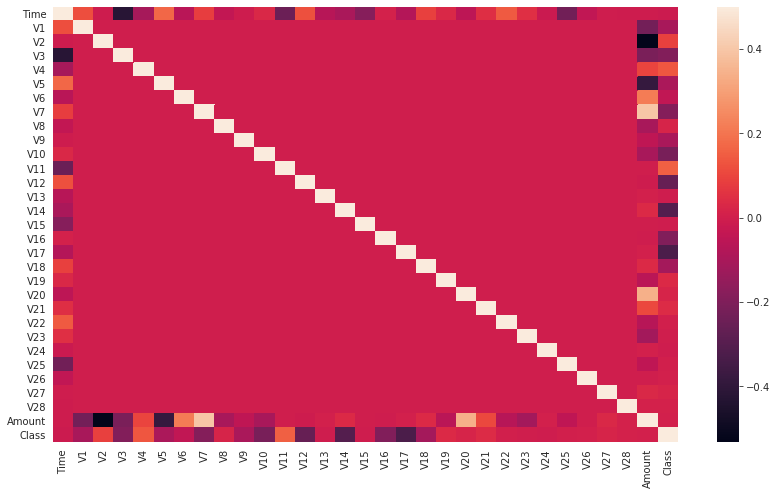

In [89]:
fig = plt.figure()

sns.heatmap(corrmat, vmax = .5)
plt.show()

   ## 2. Data Pre-processing

- Convert the dataframe into two variables, 
    - Data features - V1 - V28
    - Label column - Class

In [66]:
def prep_data(data: pd.DataFrame) -> (np.ndarray, np.ndarray):

    X = data.iloc[:, 2:30].values
    y = data.Class.values
    return X, y

- Define a fucntion to create a scatter plot based on our data and labels

In [67]:
frauds = data[data.Class==1]

normal  = data[data.Class==0]

In [68]:
def plot_data(X: np.ndarray, y: np.ndarray):
    plt.scatter(X[y == 0, 0], X[y == 0, 1], label="Class #0", alpha=0.5, linewidth=0.15)
    plt.scatter(X[y == 1, 0], X[y == 1, 1], label="Class #1", alpha=0.5, linewidth=0.15, c='r')
    plt.legend()
    return plt.show()

- Initiate the X and y variables from the prep_data function
    - Plot our data by running the initiated data points

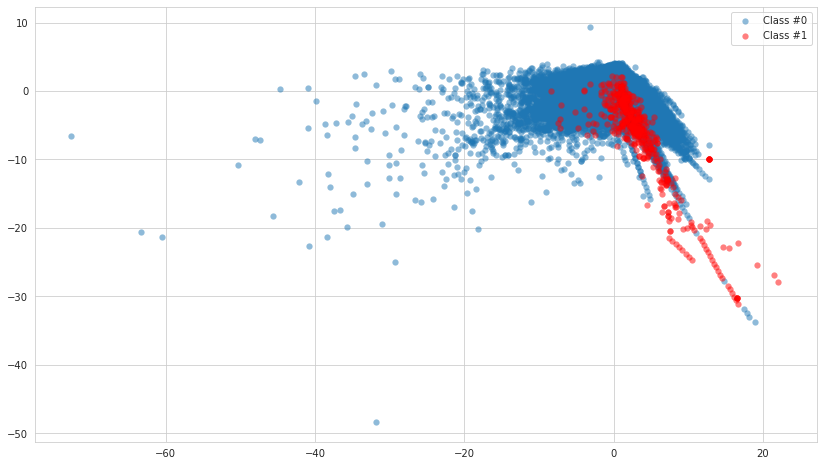

In [69]:
X, y = prep_data(data)
plot_data(X, y)

- The amount of transactions for each of the Class label

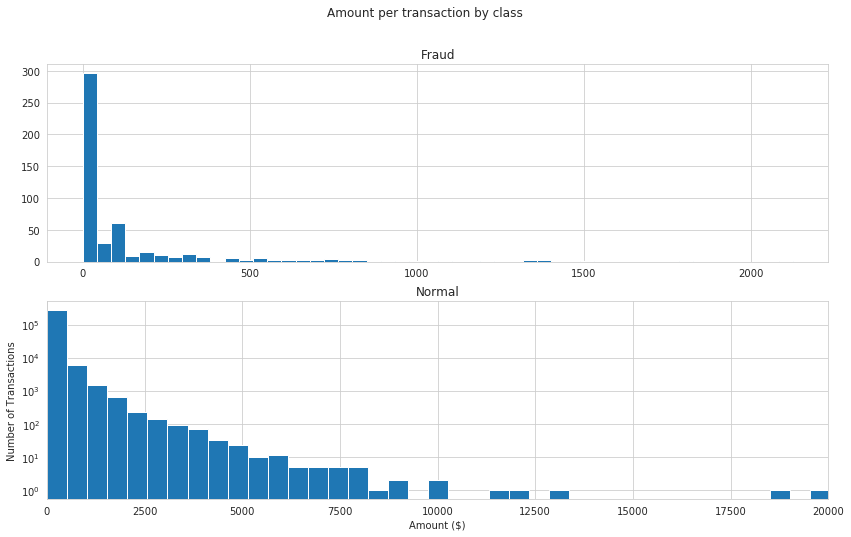

In [90]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=False)
f.suptitle('Amount per transaction by class')
bins = 50
ax1.hist(frauds.Amount, bins = bins)
ax1.set_title('Fraud')
ax2.hist(normal.Amount, bins = bins)
ax2.set_title('Normal')
plt.xlabel('Amount ($)')
plt.ylabel('Number of Transactions')
plt.xlim((0, 20000))
plt.yscale('log')
plt.show();

- The time of transaction against amount transacted per class

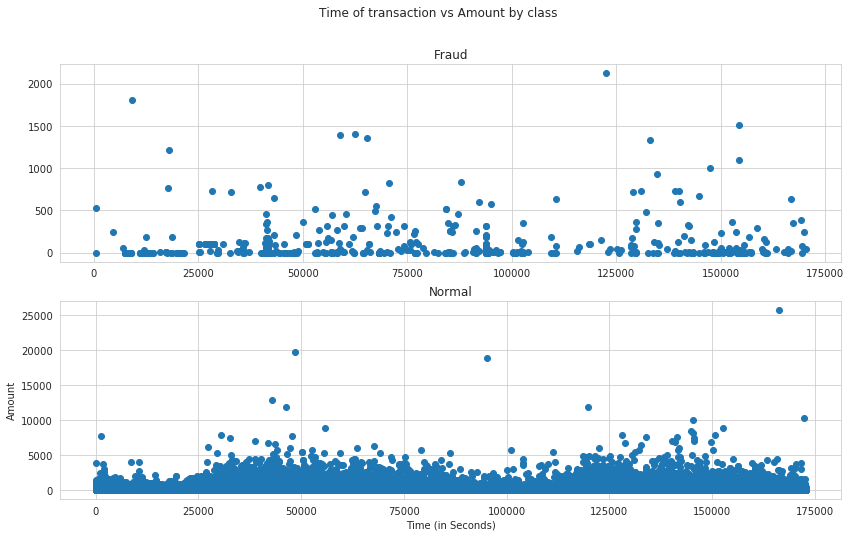

In [71]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=False)
f.suptitle('Time of transaction vs Amount by class')
ax1.scatter(frauds.Time, frauds.Amount)
ax1.set_title('Fraud')
ax2.scatter(normal.Time, normal.Amount)
ax2.set_title('Normal')
plt.xlabel('Time (in Seconds)')
plt.ylabel('Amount')
plt.show()

- From teh above distribution, we can clearly see that there is an imbalance between the two Classes of fraud
    - We will resample the training dataset using SMOTE from imblearn at the stage of splitting the data

   ## 3. Data scaling and transformation

In [15]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
np.random.seed(123)

from imblearn.over_sampling import SMOTE

- Split the dataset for training and testing

-  From the above graph, we saw that the data was imbalanced, between the two clasess. We can resample the data using imblearn's SMOTE method
    - The idea here is to upsample the fraud class to eliminate the imbalance on the training data

In [17]:
method = SMOTE()

X = data.iloc[:, 2:30]
y = data.Class  

X_validator, X_test, y_validator, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_train, X_validate, y_train, y_validate = train_test_split(X_validator, y_validator, test_size=0.2, random_state=42)

# Apply resampling to the training data only
X_resampled, y_resampled = method.fit_resample(X_train, y_train)

- We can compare the labels to see the distribution of data in each class

In [18]:
# The initial label values

pd.value_counts(pd.Series(y))

0    284315
1       492
Name: Class, dtype: int64

In [19]:
# The resampled label values

pd.value_counts(pd.Series(y_resampled))

0    159204
1    159204
Name: Class, dtype: int64

- Using Sklearn's StandardScaler, we can transform the dataset as well before we use it to build the model

In [20]:
scalar = StandardScaler()

X_train = scalar.fit_transform(X_train)
X_validate = scalar.transform(X_validate)
X_test = scalar.transform(X_test)

   ## 4. Model building

In [21]:
from tensorflow import keras

In [22]:
model = keras.Sequential([
    keras.layers.Dense(256, activation='relu', input_shape=(X_train.shape[-1],)),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(256, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(256, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(1, activation='sigmoid'),
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 256)               7424      
_________________________________________________________________
batch_normalization (BatchNo (None, 256)               1024      
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               65792     
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1024      
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               6

## 5. Training of the model

In [23]:
print("\n")
print(f"Training Set: X_train: {X_train.shape}, y_train: {y_train.shape}\n\n{'*'*60}\n")
print(f"Validation Set: X_validate: {X_validate.shape}, y_validate: {y_validate.shape}\n\n{'*'*60}\n")
print(f"Testing Set: X_test: {X_test.shape}, y_test: {y_test.shape}")
print("\n")



Training Set: X_train: (159491, 28), y_train: (159491,)

************************************************************

Validation Set: X_validate: (39873, 28), y_validate: (39873,)

************************************************************

Testing Set: X_test: (85443, 28), y_test: (85443,)




In [24]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score

def print_score(label, prediction, train=True):
    if train:
        clf_report = pd.DataFrame(classification_report(label, prediction, output_dict=True))
        print("Train Result:\n================================================")
        print(f"Accuracy Score: {accuracy_score(label, prediction) * 100:.2f}%")
        print("_______________________________________________")
        print(f"Classification Report:\n{clf_report}")
        print("_______________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(y_train, prediction)}\n")
        
    elif train==False:
        clf_report = pd.DataFrame(classification_report(label, prediction, output_dict=True))
        print("Test Result:\n================================================")        
        print(f"Accuracy Score: {accuracy_score(label, prediction) * 100:.2f}%")
        print("_______________________________________________")
        print(f"Classification Report:\n{clf_report}")
        print("_______________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(label, prediction)}\n") 

In [25]:
METRICS = [
    keras.metrics.Accuracy(name='accuracy'),
    keras.metrics.FalseNegatives(name='fn'),
    keras.metrics.FalsePositives(name='fp'),
    keras.metrics.TrueNegatives(name='tn'),
    keras.metrics.TruePositives(name='tp'),
    keras.metrics.Precision(name='precision'),
    keras.metrics.Recall(name='recall')
]

model.compile(optimizer=keras.optimizers.Adam(1e-3), loss='binary_crossentropy', metrics=METRICS)

callbacks = [keras.callbacks.ModelCheckpoint('models/fraud_model.h5', save_best_only=True,monitor='val_loss', mode='min')]

r = model.fit(
    X_train, y_train, 
    validation_data=(X_validate, y_validate),
    batch_size=32, 
    epochs=50, 
    callbacks=callbacks,
)

Epoch 1/50
4985/4985 [==============================] - 14s 3ms/step - loss: 0.0223 - accuracy: 1.8810e-05 - fn: 112.0000 - fp: 931.0000 - tn: 158273.0000 - tp: 175.0000 - precision: 0.1582 - recall: 0.6098 - val_loss: 0.0232 - val_accuracy: 0.0014 - val_fn: 12.0000 - val_fp: 30.0000 - val_tn: 39774.0000 - val_tp: 57.0000 - val_precision: 0.6552 - val_recall: 0.8261
Epoch 2/50
4985/4985 [==============================] - 14s 3ms/step - loss: 0.0051 - accuracy: 0.0000e+00 - fn: 101.0000 - fp: 46.0000 - tn: 159158.0000 - tp: 186.0000 - precision: 0.8017 - recall: 0.6481 - val_loss: 0.0113 - val_accuracy: 0.0011 - val_fn: 13.0000 - val_fp: 14.0000 - val_tn: 39790.0000 - val_tp: 56.0000 - val_precision: 0.8000 - val_recall: 0.8116
Epoch 3/50
4985/4985 [==============================] - 13s 3ms/step - loss: 0.0046 - accuracy: 0.0000e+00 - fn: 93.0000 - fp: 40.0000 - tn: 159164.0000 - tp: 194.0000 - precision: 0.8291 - recall: 0.6760 - val_loss: 0.0090 - val_accuracy: 8.0255e-04 - val_fn: 13

4985/4985 [==============================] - 18s 4ms/step - loss: 0.0022 - accuracy: 0.0000e+00 - fn: 65.0000 - fp: 28.0000 - tn: 159176.0000 - tp: 222.0000 - precision: 0.8880 - recall: 0.7735 - val_loss: 0.0040 - val_accuracy: 5.5175e-04 - val_fn: 13.0000 - val_fp: 13.0000 - val_tn: 39791.0000 - val_tp: 56.0000 - val_precision: 0.8116 - val_recall: 0.8116
Epoch 24/50
4985/4985 [==============================] - 19s 4ms/step - loss: 0.0021 - accuracy: 0.0000e+00 - fn: 58.0000 - fp: 25.0000 - tn: 159179.0000 - tp: 229.0000 - precision: 0.9016 - recall: 0.7979 - val_loss: 0.0046 - val_accuracy: 7.0223e-04 - val_fn: 13.0000 - val_fp: 14.0000 - val_tn: 39790.0000 - val_tp: 56.0000 - val_precision: 0.8000 - val_recall: 0.8116
Epoch 25/50
4985/4985 [==============================] - 18s 4ms/step - loss: 0.0021 - accuracy: 0.0000e+00 - fn: 53.0000 - fp: 26.0000 - tn: 159178.0000 - tp: 234.0000 - precision: 0.9000 - recall: 0.8153 - val_loss: 0.0042 - val_accuracy: 5.5175e-04 - val_fn: 13.000

4985/4985 [==============================] - 13s 3ms/step - loss: 0.0016 - accuracy: 0.0000e+00 - fn: 45.0000 - fp: 15.0000 - tn: 159189.0000 - tp: 242.0000 - precision: 0.9416 - recall: 0.8432 - val_loss: 0.0047 - val_accuracy: 7.7747e-04 - val_fn: 12.0000 - val_fp: 12.0000 - val_tn: 39792.0000 - val_tp: 57.0000 - val_precision: 0.8261 - val_recall: 0.8261
Epoch 46/50
4985/4985 [==============================] - 13s 3ms/step - loss: 0.0017 - accuracy: 0.0000e+00 - fn: 52.0000 - fp: 22.0000 - tn: 159182.0000 - tp: 235.0000 - precision: 0.9144 - recall: 0.8188 - val_loss: 0.0044 - val_accuracy: 6.0191e-04 - val_fn: 12.0000 - val_fp: 9.0000 - val_tn: 39795.0000 - val_tp: 57.0000 - val_precision: 0.8636 - val_recall: 0.8261
Epoch 47/50
4985/4985 [==============================] - 14s 3ms/step - loss: 0.0016 - accuracy: 0.0000e+00 - fn: 47.0000 - fp: 22.0000 - tn: 159182.0000 - tp: 240.0000 - precision: 0.9160 - recall: 0.8362 - val_loss: 0.0060 - val_accuracy: 8.0255e-04 - val_fn: 12.0000

## 6. Extraction of rules, trends or patterns

In [26]:
from apyori import apriori

- Create a copy of the dataset with features that can be used in the extraction of rules
    - Time
    - Amount
    - Class

In [27]:
d_copy = data.copy()
d_copy.drop(d_copy.iloc[:, 1:-2], inplace = True, axis = 1)
d_copy.head(2)

,Time,Amount,Class
0,0.0,149.62,0
1,0.0,2.69,0


In [28]:
association_rules = apriori(d_copy, min_support=0.07, min_confidence=0.5, min_lift=1, min_length=3)  
association_results = list(association_rules)
support=[]
items=[]
rhs=[]
lhs=[]
con=[]
lift=[]
for i in association_results:
    support.append(i.support)
    items.append(i.items)
    rhs.append(i.ordered_statistics[0][1])
    lhs.append(i.ordered_statistics[0][0])
    con.append(i.ordered_statistics[0][2])
    lift.append(i.ordered_statistics[0][3])

In [29]:
df=pd.DataFrame({'Items':items,'Antecedent':lhs,'Precedent':rhs,'Support':support, 'Confidence':con,'Lift':lift})

In [30]:
df.head()

,Items,Antecedent,Precedent,Support,Confidence,Lift
0,(m),(),(m),0.666667,0.666667,1.0
1,"(A, m)",(A),(m),0.333333,1.000000,1.5
2,"(n, A)",(A),(n),0.333333,1.000000,3.0
3,"(o, A)",(A),(o),0.333333,1.000000,3.0
4,"(A, t)",(A),(t),0.333333,1.000000,3.0


## 7. Visualization of  rules, trends or patterns

In [31]:
for i,items in df.iterrows():
    
    print("Rule: " + str(items['Antecedent']) + " -> " + str(items['Precedent']))
    print("Support: " + str(items['Support']))
    print("Confidence: " + str(items['Confidence']))
    print("Lift: " + str(items['Lift']))
    print("**"*40 + '\n')

Rule: frozenset() -> frozenset({'m'})
Support: 0.6666666666666666
Confidence: 0.6666666666666666
Lift: 1.0
********************************************************************************

Rule: frozenset({'A'}) -> frozenset({'m'})
Support: 0.3333333333333333
Confidence: 1.0
Lift: 1.5
********************************************************************************

Rule: frozenset({'A'}) -> frozenset({'n'})
Support: 0.3333333333333333
Confidence: 1.0
Lift: 3.0
********************************************************************************

Rule: frozenset({'A'}) -> frozenset({'o'})
Support: 0.3333333333333333
Confidence: 1.0
Lift: 3.0
********************************************************************************

Rule: frozenset({'A'}) -> frozenset({'t'})
Support: 0.3333333333333333
Confidence: 1.0
Lift: 3.0
********************************************************************************

Rule: frozenset({'A'}) -> frozenset({'u'})
Support: 0.3333333333333333
Confidence: 1.0
Lift: 3.

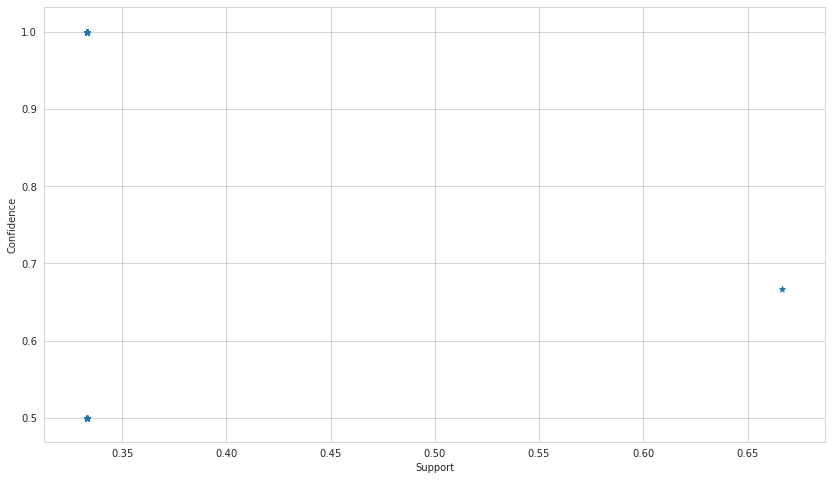

In [72]:
plt.scatter(df['Support'], df['Confidence'], marker="*")
plt.xlabel('Support')
plt.ylabel('Confidence') 
plt.show()

## 8. Model Evaluation Techniques

- Get an overview of the test metrics performance

In [35]:
score = model.evaluate(X_test, y_test)
print(score)

2671/2671 [==============================] - 3s 994us/step - loss: 0.0034 - accuracy: 6.0859e-04 - fn: 23.0000 - fp: 33.0000 - tn: 85274.0000 - tp: 113.0000 - precision: 0.7740 - recall: 0.8309
[0.003355090506374836, 0.0006085928762331605, 23.0, 33.0, 85274.0, 113.0, 0.7739726305007935, 0.8308823704719543]


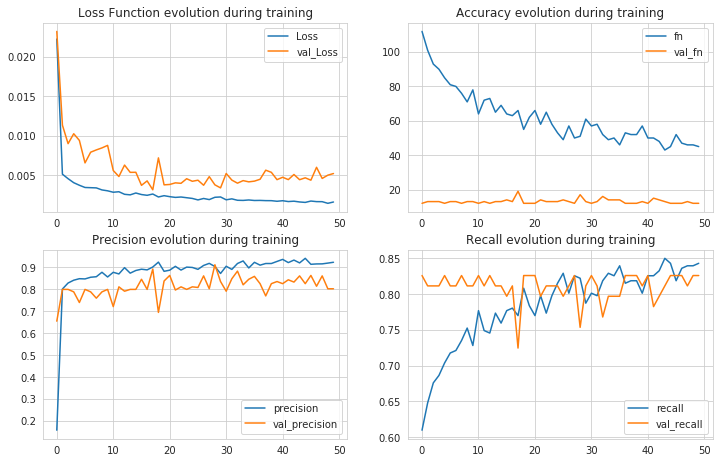

In [36]:
plt.figure(figsize=(12, 16))

plt.subplot(4, 2, 1)
plt.plot(r.history['loss'], label='Loss')
plt.plot(r.history['val_loss'], label='val_Loss')
plt.title('Loss Function evolution during training')
plt.legend()

plt.subplot(4, 2, 2)
plt.plot(r.history['fn'], label='fn')
plt.plot(r.history['val_fn'], label='val_fn')
plt.title('Accuracy evolution during training')
plt.legend()

plt.subplot(4, 2, 3)
plt.plot(r.history['precision'], label='precision')
plt.plot(r.history['val_precision'], label='val_precision')
plt.title('Precision evolution during training')
plt.legend()

plt.subplot(4, 2, 4)
plt.plot(r.history['recall'], label='recall')
plt.plot(r.history['val_recall'], label='val_recall')
plt.title('Recall evolution during training')
plt.legend()

In [37]:
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

print_score(y_train, y_train_pred.round(), train=True)
print_score(y_test, y_test_pred.round(), train=False)

scores_dict = {
    'ANNs': {
        'Train': f1_score(y_train, y_train_pred.round()),
        'Test': f1_score(y_test, y_test_pred.round()),
    },
}

Train Result:
Accuracy Score: 99.96%
_______________________________________________
Classification Report:
                       0           1  accuracy      macro avg   weighted avg
precision       0.999805    0.904594  0.999636       0.952199       0.999634
recall          0.999830    0.891986  0.999636       0.945908       0.999636
f1-score        0.999818    0.898246  0.999636       0.949032       0.999635
support    159204.000000  287.000000  0.999636  159491.000000  159491.000000
_______________________________________________
Confusion Matrix: 
 [[159177     27]
 [    31    256]]

Test Result:
Accuracy Score: 99.93%
_______________________________________________
Classification Report:
                      0           1  accuracy     macro avg  weighted avg
precision      0.999730    0.773973  0.999345      0.886851      0.999371
recall         0.999613    0.830882  0.999345      0.915248      0.999345
f1-score       0.999672    0.801418  0.999345      0.900545      0.999356


## 9. Optimizing the evaluated model